In [20]:
import pandas as pd
pd.set_option('display.width', None)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import preprocessing

## Carga y Preprocesamiento

In [21]:
import duckdb
conexion = duckdb.connect("../project_db.db")

In [22]:
create_comments_query = "CREATE OR REPLACE TABLE COMMENTS AS SELECT * FROM 'the-reddit-covid-dataset-comments.csv';"

conexion.query(create_comments_query)

IOException: IO Error: No files found that match the pattern "the-reddit-covid-dataset-comments.csv"

In [ ]:
create_posts_query = "CREATE OR REPLACE TABLE POSTS AS SELECT * FROM 'the-reddit-covid-dataset-posts.csv';"

conexion.query(create_posts_query)

In [ ]:
#Creacion de columna con el post id
conexion.query("ALTER TABLE COMMENTS ADD COLUMN POST_ID VARCHAR;")


In [ ]:
conexion.query("UPDATE COMMENTS SET POST_ID = substring(permalink, instr(permalink, '/comments/') + length('/comments/'), 6);")

In [ ]:
conexion.query("UPDATE COMMENTS SET POST_ID = substring(permalink, 0, -1) where post_id like '%/';")

In [ ]:
#Creacion de columna para el datetime
conexion.query("ALTER TABLE COMMENTS ADD COLUMN CREATED_AT TIMESTAMP;")
conexion.query("UPDATE COMMENTS SET CREATED_AT = TO_TIMESTAMP(created_utc);")

In [ ]:
#Creacion de columna para el datetime
conexion.query("ALTER TABLE POSTS ADD COLUMN CREATED_AT TIMESTAMP;")
conexion.query("UPDATE POSTS SET CREATED_AT = TO_TIMESTAMP(created_utc);")

In [ ]:
#Creacion de columna con sentimiento categorizado
conexion.query("ALTER TABLE COMMENTS ADD COLUMN CAT_SENTIMIENT VARCHAR;")


In [ ]:
conexion.query("UPDATE COMMENTS \
               SET CAT_SENTIMIENT = CASE WHEN sentiment > 0.4 THEN 'POSITIVO' \
                                        WHEN (sentiment <= 0.4 AND sentiment >= -0.4) THEN 'NEUTRO' \
                                        WHEN sentiment < -0.4 THEN  'NEGATIVO' END;")

In [ ]:
#creacion de vista con join entre comments y posts
CREATE_VIEW_QUERY = "CREATE OR REPLACE VIEW COMMENTS_WITH_POSTS AS \
select cmts.id, cmts.\"subreddit.id\" as subreddit_id, cmts.\"subreddit.name\" as subreddit_name, cmts.\"subreddit.nsfw\" as nsfw,\
    cmts.body, cmts.sentiment, cmts.score as comment_score, cmts.CREATED_AT as comment_date, cmts.POST_ID as post_id, psts.CREATED_AT as post_date, psts.domain, psts.title, psts.score as post_score \
    from COMMENTS cmts \
    LEFT JOIN POSTS psts on psts.id = cmts.post_id"
conexion.query(CREATE_VIEW_QUERY)

Eliminando post y comentarios anterior a la pandemia

In [ ]:
conexion.query("select * from posts where date_trunc('year',created_at) < '2019-12-01' order by created_at desc").df()

In [ ]:
conexion.query("select * from comments where created_at < '2019-12-01' order by created_at desc").df().body

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Se filtra los post y comentarios por fechas anteriores al comienzo de la pandemia, estos comentarios contienen la palabra covid pero no a la enfermedad, unos hablan de arte, technologias, y en otras ocaciones parece ser una palabra en otro idioma

In [ ]:
conexion.query("DELETE FROM posts WHERE created_at < '2019-12-01';")

In [ ]:
conexion.query("DELETE FROM comments WHERE created_at < '2019-12-01';")

## Analisis Exploratorio

In [ ]:
conexion.query("select * from comments limit 10").to_df()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score,POST_ID,CREATED_AT
0,comment,hi1vsag,2riyy,nova,False,1635206399,https://old.reddit.com/r/nova/comments/qfs53d/...,When you scheduled your booster with CVS does ...,0.0000,2,qfs53d,2021-10-25 18:59:59
1,comment,hi1vs7i,2qhov,vancouver,False,1635206397,https://old.reddit.com/r/vancouver/comments/qf...,Didn't stop prices there though. New Zealand a...,0.1887,32,qft2x3,2021-10-25 18:59:57
2,comment,hi1vs5n,2qwzb,pregnant,False,1635206397,https://old.reddit.com/r/pregnant/comments/qfs...,I’m just waiting until after pregnancy to get ...,0.6720,1,qfsajl,2021-10-25 18:59:57
3,comment,hi1vs5v,2qixm,startrek,False,1635206397,https://old.reddit.com/r/startrek/comments/qft...,*The first duty of every Starfleet officer is ...,0.9562,1,qftvn2,2021-10-25 18:59:57
4,comment,hi1vs0l,2qsf3,ontario,False,1635206395,https://old.reddit.com/r/ontario/comments/qfkj...,Compare BC to Ontario for COVID. It's even mor...,0.0000,-2,qfkjyn,2021-10-25 18:59:55
5,comment,hi1vrtk,2qh0f,entertainment,False,1635206393,https://old.reddit.com/r/entertainment/comment...,Sheeran didn't mention whether he was vaccinat...,0.5023,2,qf15t6,2021-10-25 18:59:53
6,comment,hi1vrsk,2qh4r,conspiracy,False,1635206392,https://old.reddit.com/r/conspiracy/comments/q...,I see a lot of posts like this comparing the c...,0.2440,1,qfjjlb,2021-10-25 18:59:52
7,comment,hi1vrnr,2iokxd,lockdownskepticism,False,1635206391,https://old.reddit.com/r/LockdownSkepticism/co...,And think about how many people died over the ...,-0.8413,29,qfkxc8,2021-10-25 18:59:51
8,comment,hi1vrpy,2riyy,nova,False,1635206391,https://old.reddit.com/r/nova/comments/qfpng6/...,Unfortunately they shut down during covid. I'v...,-0.1779,2,qfpng6,2021-10-25 18:59:51
9,comment,hi1vrou,384mz,antivaxxers,False,1635206391,https://old.reddit.com/r/AntiVaxxers/comments/...,I don’t know anyone unvaccinated that has died...,-0.9191,1,q7ckxl,2021-10-25 18:59:51


In [ ]:
conexion.query("select * from posts limit 10").to_df()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score,CREATED_AT
0,post,qftvfn,3h9d4,autonewspaper,False,1635206379,https://old.reddit.com/r/AutoNewspaper/comment...,washingtontimes.com,https://www.washingtontimes.com/news/2021/oct/...,None,"[Politics] - Kay Ivey, Alabama governor, direc...",1,2021-10-25 18:59:39
1,post,qftusg,2x4yx,coronavirus,False,1635206322,https://old.reddit.com/r/Coronavirus/comments/...,twitter.com,None,[deleted],More Floridians dead from COVID than Vietnam W...,1,2021-10-25 18:58:42
2,post,qftugv,3h9d4,autonewspaper,False,1635206292,https://old.reddit.com/r/AutoNewspaper/comment...,nzherald.co.nz,https://www.nzherald.co.nz/nz/news/article.cfm...,None,[NZ] - Covid-19 coronavirus Delta outbreak: La...,1,2021-10-25 18:58:12
3,post,qftuge,3h9d4,autonewspaper,False,1635206291,https://old.reddit.com/r/AutoNewspaper/comment...,nzherald.co.nz,https://www.nzherald.co.nz/nz/news/article.cfm...,None,[NZ] - Covid 19 Delta outbreak: Man arrested a...,1,2021-10-25 18:58:11
4,post,qftucd,4egz78,cointuta,False,1635206281,https://old.reddit.com/r/CoinTuta/comments/qft...,cointuta.com,https://www.cointuta.com/covid-19-more-likely-...,None,Covid-19 more likely to cause neurological iss...,1,2021-10-25 18:58:01
5,post,qftuah,2qhh9,quebec,False,1635206276,https://old.reddit.com/r/Quebec/comments/qftua...,self.quebec,None,https://support.apple.com/en-ca/HT212752\n\nAv...,Le saviez-vous ? Sous iOS 15.1 vous pouvez raj...,0,2021-10-25 18:57:56
6,post,qftu6e,3h9d4,autonewspaper,False,1635206265,https://old.reddit.com/r/AutoNewspaper/comment...,bbc.co.uk,https://www.bbc.co.uk/news/world-us-canada-590...,None,[US] - Covid vaccines: Paediatricians on front...,1,2021-10-25 18:57:45
7,post,qftu5s,2x4yx,coronavirus,False,1635206263,https://old.reddit.com/r/Coronavirus/comments/...,nbcnewyork.com,None,[deleted],More Floridians dead from COVID than Vietnam war.,1,2021-10-25 18:57:43
8,post,qftu1w,3h9d4,autonewspaper,False,1635206252,https://old.reddit.com/r/AutoNewspaper/comment...,chicago.suntimes.com,https://chicago.suntimes.com/consumer-affairs/...,None,[Politics] - Older people increasingly targete...,1,2021-10-25 18:57:32
9,post,qfttfl,2qh4r,conspiracy,False,1635206193,https://old.reddit.com/r/conspiracy/comments/q...,self.conspiracy,None,I’m not getting the vaxx. Many friends and fam...,I have health anxiety and I’m actually getting...,4,2021-10-25 18:56:33


TOP 10 subreddits donde mas se habla de covid

In [ ]:
top_10_count_subreddits = conexion.query("select \"subreddit.id\" as subreddit_id, \"subreddit.name\" as subreddit_name, count(*) as ncomments from COMMENTS group by \"subreddit.id\", \"subreddit.name\" order by count(*) DESC limit 10").to_df()
top_10_count_subreddits

,subreddit_id,subreddit_name,ncomments
0,2x4yx,coronavirus,571078
1,2cneq,politics,552065
2,2qh1i,askreddit,551938
3,2qh4r,conspiracy,378622
4,2qh3l,news,322446
5,2qh13,worldnews,313824
6,2q5yp2,nonewnormal,185580
7,2xhvq,amitheasshole,147652
8,2th52,wallstreetbets,137147
9,2yrq6,publicfreakout,117681


In [ ]:
top_10_count_subreddits.subreddit_id.to_list()

['2x4yx',
 '2cneq',
 '2qh1i',
 '2qh4r',
 '2qh3l',
 '2qh13',
 '2q5yp2',
 '2xhvq',
 '2th52',
 '2yrq6']

In [ ]:
conexion.query("select count(*) from comments where CAT_SENTIMIENT is null").to_df()

,count_star()
0,750309


In [ ]:
conexion.query("select body, sentiment from comments where CAT_SENTIMIENT is null limit 10").to_df()

,body,sentiment
0,"Octubre 25, 2021\n\nMéxico ha aplicado 115 mil...",NaN
1,"ai covid bro, da-i cu palinca sa dezinfectezi ...",NaN
2,Covid.,NaN
3,"Ja, genau, es ist alles egal. Die Gesellschaft...",NaN
4,https://retractionwatch.com/2021/10/04/author-...,NaN
5,[https://tennesseestands.org/commentary/a-nurs...,NaN
6,"Sí, desde hace como 4 meses, sólo de repente q...",NaN
7,"No preocupado por mi, pase el covid como si na...",NaN
8,Nunca gostei de carnaval.\nE outra coisa:vírus...,NaN
9,"Tentamos isso hoje , mas a escola mostra total...",NaN


In [ ]:
top_10_subreddits_sentiment = conexion.query("select \"subreddit.id\" as subreddit_id, \"subreddit.name\" as subreddit_name, CAT_SENTIMIENT, count(*) as ncomments \
                                             from COMMENTS \
                                             where subreddit_id in ('2x4yx','2qh1i','2cneq','2qh4r','2qh3l','2qh13','2q5yp2','2xhvq','2th52','2yrq6')\
                                             and CAT_SENTIMIENT is not null \
                                             group by \"subreddit.id\", \"subreddit.name\", CAT_SENTIMIENT order by count(*)").to_df()
top_10_subreddits_sentiment

,subreddit_id,subreddit_name,CAT_SENTIMIENT,ncomments
0,2yrq6,publicfreakout,POSITIVO,26315
1,2xhvq,amitheasshole,NEUTRO,31041
2,2th52,wallstreetbets,NEGATIVO,37187
3,2yrq6,publicfreakout,NEUTRO,39800
4,2th52,wallstreetbets,POSITIVO,40414
5,2xhvq,amitheasshole,NEGATIVO,43447
6,2q5yp2,nonewnormal,POSITIVO,44070
7,2yrq6,publicfreakout,NEGATIVO,49133
8,2th52,wallstreetbets,NEUTRO,56007
9,2q5yp2,nonewnormal,NEUTRO,56726


In [ ]:
top_10_subreddits_sentiment['porcentaje'] = top_10_subreddits_sentiment['ncomments'] / top_10_subreddits_sentiment.groupby('subreddit_name')['ncomments'].transform('sum')

In [ ]:
top_10_subreddits_sentiment

,subreddit_id,subreddit_name,CAT_SENTIMIENT,ncomments,porcentaje
0,2yrq6,publicfreakout,POSITIVO,26315,0.228334
1,2xhvq,amitheasshole,NEUTRO,31041,0.210655
2,2th52,wallstreetbets,NEGATIVO,37187,0.278329
3,2yrq6,publicfreakout,NEUTRO,39800,0.345342
4,2th52,wallstreetbets,POSITIVO,40414,0.302482
5,2xhvq,amitheasshole,NEGATIVO,43447,0.294846
6,2q5yp2,nonewnormal,POSITIVO,44070,0.246428
7,2yrq6,publicfreakout,NEGATIVO,49133,0.426324
8,2th52,wallstreetbets,NEUTRO,56007,0.419189
9,2q5yp2,nonewnormal,NEUTRO,56726,0.317197


(0.0, 250000.0)

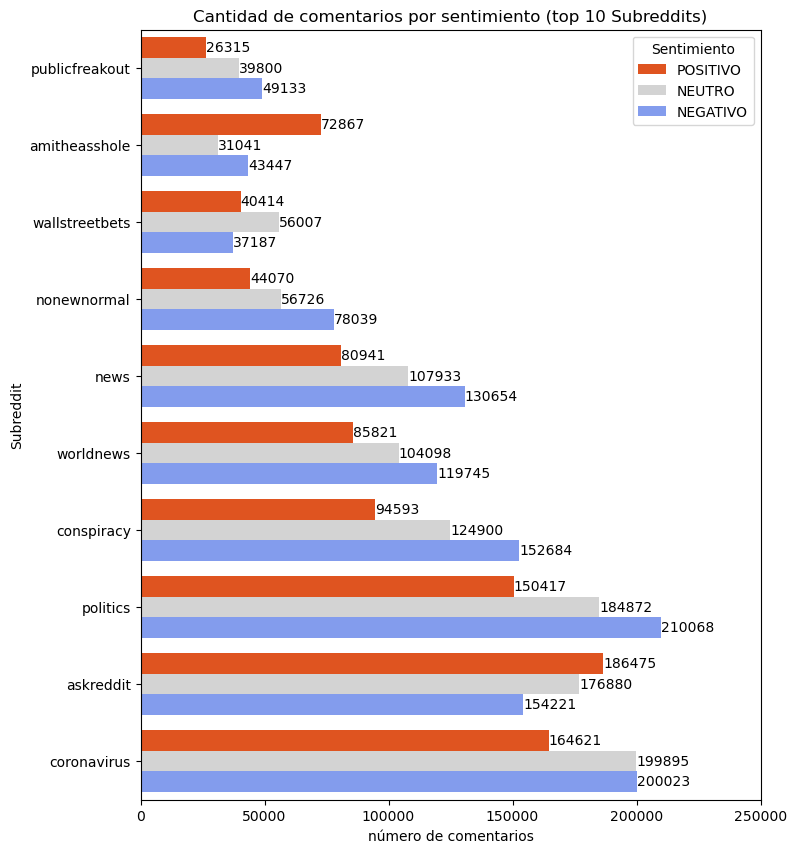

In [ ]:
# create the plot
fig, ax = plt.subplots(figsize=(8, 10))
sns.barplot(data=top_10_subreddits_sentiment, y='subreddit_name', x='ncomments', hue='CAT_SENTIMIENT', ax=ax, palette=["#ff4500", "lightgrey", "#7193ff"])
plt.title('Cantidad de comentarios por sentimiento (top 10 Subreddits)')
plt.ylabel('Subreddit')
plt.xlabel('número de comentarios')
# iterate through the axes bar containers
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title='Sentimiento')
ax.set_xlim([0, 250000])


(0.0, 1.0)

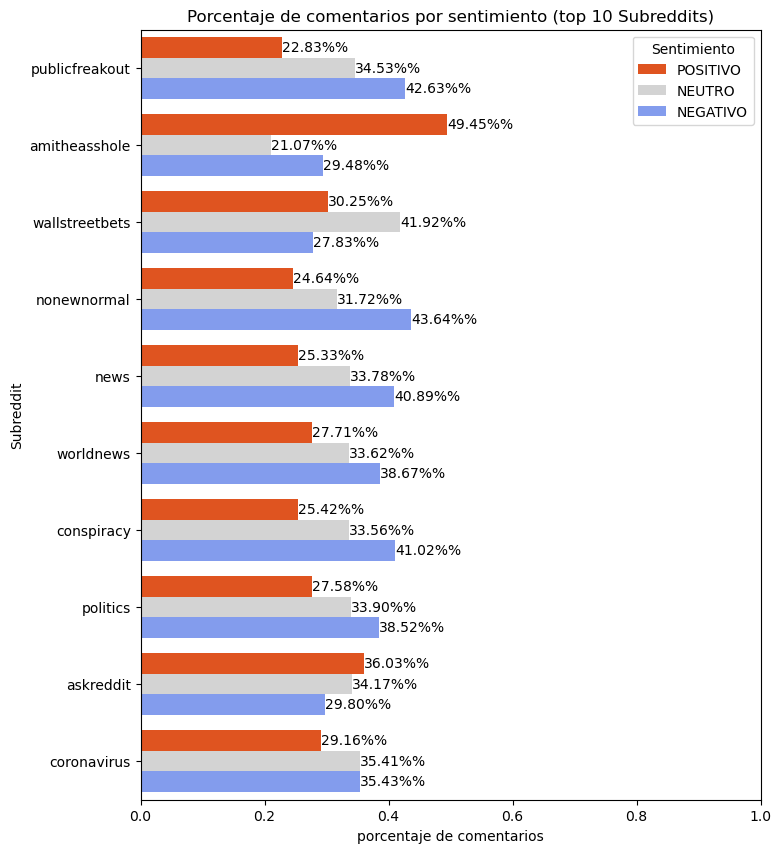

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.barplot(data=top_10_subreddits_sentiment, y='subreddit_name', x='porcentaje', hue='CAT_SENTIMIENT', ax=ax, palette=["#ff4500", "lightgrey", "#7193ff"])

plt.title('Porcentaje de comentarios por sentimiento (top 10 Subreddits)')
plt.ylabel('Subreddit')
plt.xlabel('porcentaje de comentarios')

for container in ax.containers:
    ax.bar_label(container,fmt='{:.2%}%')
plt.legend(title='Sentimiento')
ax.set_xlim([0, 1])

[Text(0, 0, '571078'),
 Text(0, 0, '552065'),
 Text(0, 0, '551938'),
 Text(0, 0, '378622'),
 Text(0, 0, '322446'),
 Text(0, 0, '313824'),
 Text(0, 0, '185580'),
 Text(0, 0, '147652'),
 Text(0, 0, '137147'),
 Text(0, 0, '117681')]

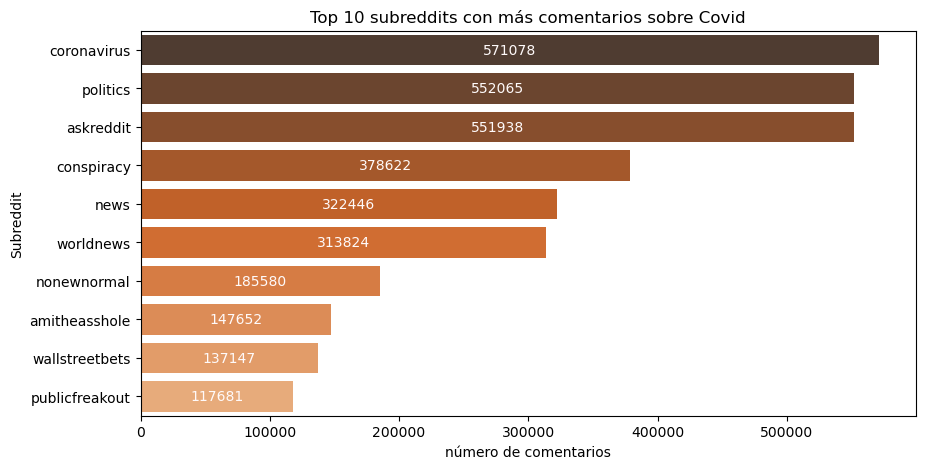

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=top_10_count_subreddits, y='subreddit_name', x='ncomments', ax=ax)

pal = sns.color_palette("Oranges_r_d", len(top_10_count_subreddits))
ax = sns.barplot(data=top_10_count_subreddits, y='subreddit_name', x='ncomments', palette=pal, hue='subreddit_name', legend=False)
plt.title('Top 10 subreddits con más comentarios sobre Covid')
plt.ylabel('Subreddit')
plt.xlabel('número de comentarios')
#plt.xlim(0, max(top_10_count_subreddits['ncomments']) + max(top_10_count_subreddits['ncomments']) * 0.2)
ax.bar_label(ax.containers[0], label_type='center', color='snow')

- Obviamente en el top se iba a encontrar el subreddit sobre coronavirus. 
- Subreddits como politics, news, worldnews estan en el top porque son ssubreddits donde se hablan de noticias y covid generaba reportes cada dia con el numero de muertos, nuevos sintomas, reportajes de como tomar precauciones, etc (politics reporta sobre como el gobierno esta actuando frente a la crisis)
- nonewnormal y conspiracy hablaban de como covid era una mentira y las vacunas eran dañiñas, asi que se discutia bastante el covid pero de manera exceptica

top 10 Subreddits con mejor scores

In [ ]:
top_10_score_subreddits = conexion.query("select \"subreddit.id\" as subreddit_id, \"subreddit.name\" as subreddit_name, sum(score) as sum_score from COMMENTS group by \"subreddit.id\", \"subreddit.name\" order by sum(score) DESC limit 10").to_df()
top_10_score_subreddits

,subreddit_id,subreddit_name,sum_score
0,2cneq,politics,10630325.0
1,2qh1i,askreddit,9359561.0
2,2x4yx,coronavirus,7756541.0
3,2qh3l,news,7623870.0
4,2qh13,worldnews,6045263.0
5,35e6ns,hermancainaward,2341170.0
6,2xhvq,amitheasshole,2289275.0
7,2yrq6,publicfreakout,1808359.0
8,2qh4r,conspiracy,1784641.0
9,2qh0u,pics,1697107.0


top subreddits con sentimiento mas postivo 

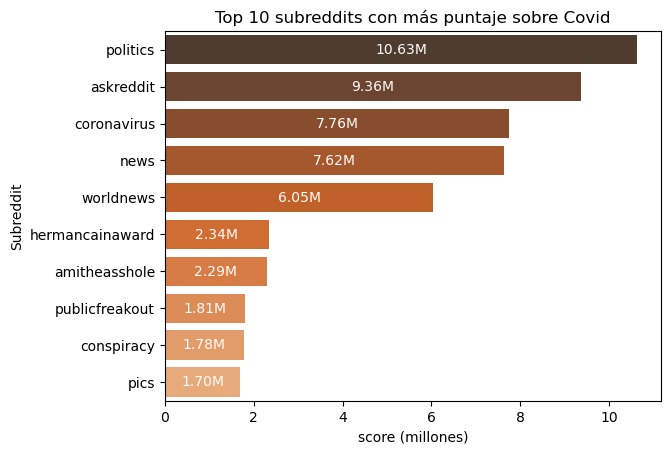

In [ ]:
top_10_score_subreddits['sum_score_millones'] = top_10_score_subreddits['sum_score']/1000000

pal = sns.color_palette("Oranges_r_d", len(top_10_score_subreddits))
ax = sns.barplot(data=top_10_score_subreddits, y='subreddit_name', x='sum_score_millones', palette=pal, hue='subreddit_name', legend=False)
plt.title('Top 10 subreddits con más puntaje sobre Covid')
plt.ylabel('Subreddit')
plt.xlabel('score (millones)')
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='snow', fmt='{:,.2f}M')

- El grafico el top 10 subreddits con mayores puntuaciones tiene subreddits similares al top 10 por cantidad de comentarios
- conspiracy baja de ranking y nonewnormal no está entre las top a pesar de tener una alta cantidad de comentarios probablemente por su posicion sobre las vacunas

TOP 10 dominios más linkeados

In [ ]:
top_10_Domains_wo_reddit = conexion.query("select domain, count(id) as nposts from posts where domain not like '%redd%' group by domain order by count(id) DESC limit 10 ").to_df()
top_10_Domains_wo_reddit

,domain,nposts
0,cbc.ca,471982
1,thestar.com,166297
2,toronto.ctvnews.ca,165130
3,globalnews.ca,108908
4,youtube.com,95723
5,mobile.twitter.com,80386
6,theguardian.com,73112
7,youtu.be,58387
8,twitter.com,51399
9,ddnews.gov.in,41427


In [ ]:
top_10_Domains = conexion.query("select domain, count(id) as nposts from posts group by domain order by count(id) DESC limit 10 ").to_df()
top_10_Domains

,domain,nposts
0,cbc.ca,471982
1,i.redd.it,254626
2,thestar.com,166297
3,toronto.ctvnews.ca,165130
4,globalnews.ca,108908
5,youtube.com,95723
6,self.askreddit,84871
7,mobile.twitter.com,80386
8,theguardian.com,73112
9,reddit.com,58399


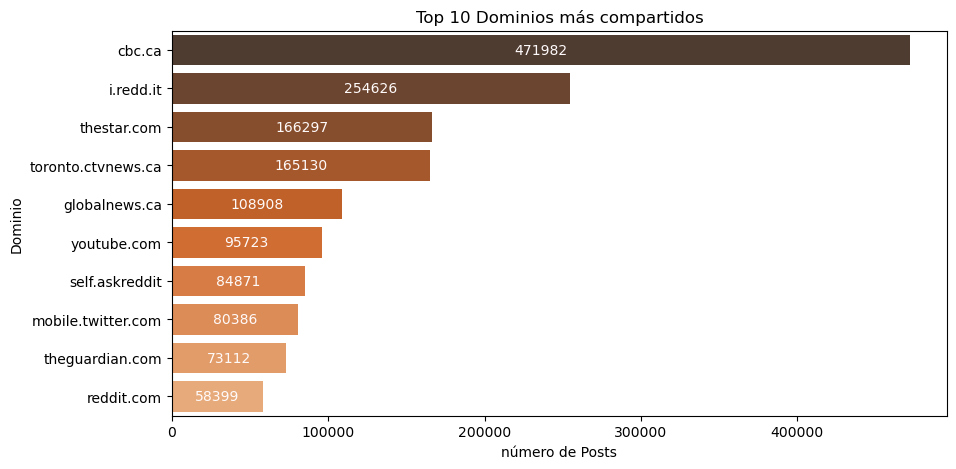

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))


pal = sns.color_palette("Oranges_r_d", len(top_10_Domains))
ax = sns.barplot(data=top_10_Domains, y='domain', x='nposts', palette=pal, hue='domain', legend=False)
plt.title('Top 10 Dominios más compartidos')
plt.ylabel('Dominio')
plt.xlabel('número de Posts')
#plt.xlim(0, max(top_10_count_subreddits['ncomments']) + max(top_10_count_subreddits['ncomments']) * 0.2)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='snow')

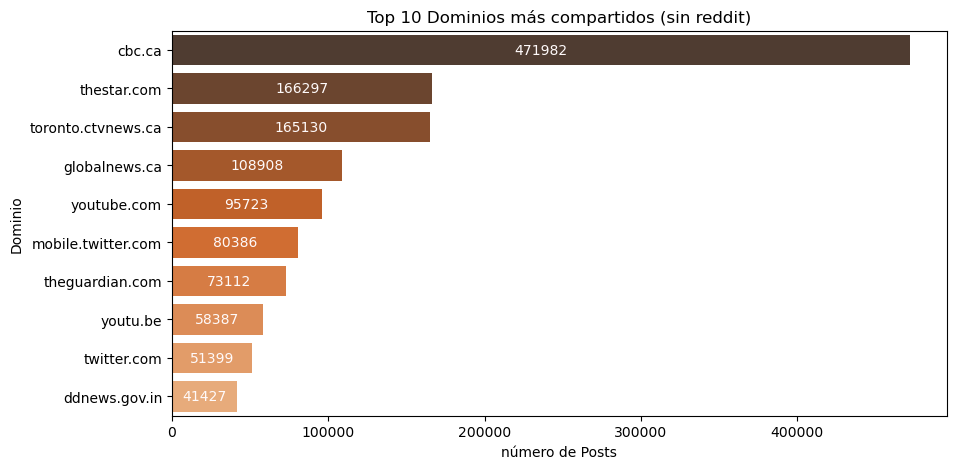

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))


pal = sns.color_palette("Oranges_r_d", len(top_10_Domains_wo_reddit))
ax = sns.barplot(data=top_10_Domains_wo_reddit, y='domain', x='nposts', palette=pal, hue='domain', legend=False)
plt.title('Top 10 Dominios más compartidos (sin reddit)')
plt.ylabel('Dominio')
plt.xlabel('número de Posts')
#plt.xlim(0, max(top_10_count_subreddits['ncomments']) + max(top_10_count_subreddits['ncomments']) * 0.2)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='snow')

- Hay varios sitios de noticias canadienses en el top cbc.ca, thestar.com, toronto.ctcnews.ca, globalnews.ca
- tambien hay varios posts que linkean a reddit mismo, i.redd.it son post donde el usuario sube sus propias imagenes, self.askreddit y reddit.com referencian a posts realizados en reddit.

In [ ]:
#top subreddits con sentimiento mas postivo (más de 1000 comentarios )
top_positive_subreddit = conexion.query("select \"subreddit.id\" as subreddit_id, \"subreddit.name\" as subreddit_name, count(*) as ncomments, avg(sentiment) as avg_sentiment from COMMENTS group by \"subreddit.id\", \"subreddit.name\" HAVING count(*) >= 10000 order by avg(sentiment) DESC limit 20").to_df()
top_positive_subreddit

,subreddit_id,subreddit_name,ncomments,avg_sentiment
0,389bs,r4rasian,12683,0.969500
1,2qp7z,abortion,13783,0.902694
2,2u00l,baltimoreanddcr4r,24634,0.796375
3,2rzac,paypal,23958,0.637847
4,2rv3t,weddingplanning,19400,0.493967
5,3a1qf,brasilnoticias,14943,0.487600
6,2tx47,random_acts_of_amazon,10750,0.474620
7,2fp314,ddnews,77478,0.457309
8,34cyw,datingoverthirty,12846,0.392121
9,2s4kl,dating_advice,11877,0.386534


In [ ]:
#top subreddits con sentimiento mas negativos (más de 1000 comentarios )
top_positive_subreddit = conexion.query("select \"subreddit.id\" as subreddit_id, \"subreddit.name\" as subreddit_name, count(*) as ncomments, avg(sentiment) as avg_sentiment from COMMENTS group by \"subreddit.id\", \"subreddit.name\" HAVING count(*) >= 1000 order by avg(sentiment) asc limit 20").to_df()
top_positive_subreddit

,subreddit_id,subreddit_name,ncomments,avg_sentiment
0,10adn2,tacomar4r,1839,-0.527849
1,2gwhfo,covid19_ohio,4274,-0.444942
2,f4evt,isopods,1759,-0.372125
3,2qqdb,bad_cop_no_donut,2870,-0.284590
4,2r3oh,banned,2067,-0.268210
5,3amv4,aznidentity,4236,-0.259351
6,2tz1e,morbidreality,2579,-0.245048
7,3expj,thedickshow,1197,-0.235237
8,27mtyi,actualpublicfreakouts,12555,-0.229936
9,3328c,pussypassdenied,1259,-0.221470


TOP 10 POSTS CON MAS COMENTARIOS

In [ ]:
top_10_count_comentarios = conexion.query("select post_id, title, post_score, count(*) as ncomments from COMMENTS_WITH_POSTS where title is not null group by post_id, title, post_score order by count(*) DESC limit 10").to_df()
top_10_count_comentarios

,post_id,title,post_score,ncomments
0,psin9a,What are some of the darker effects Covid-19 h...,59514,4156
1,mvicaw,Doctors of Reddit: What happened when you diag...,76679,3191
2,i1aa0m,"If Covid never happened, what all would've you...",81020,2974
3,gbpvz2,"It's time for a new ""This situation"" megathrea...",765,2410
4,gf2ghm,"Megathread: COVID-19 Opinions, Vents and Rants...",128,2127
5,ld4pu8,"After almost 1 year, are you satisfied with yo...",51036,1876
6,k18dam,How do you cope with being treated like you ar...,112641,1779
7,pfyqqn,COVID denialism and policy clarifications,17865,1675
8,ov6pmw,‘I should have gotten the damn vaccine’: Fathe...,76256,1626
9,n1i01l,Flu Has Disappeared Worldwide during the COVID...,57304,1609


<Axes: xlabel='ncomments', ylabel='title'>

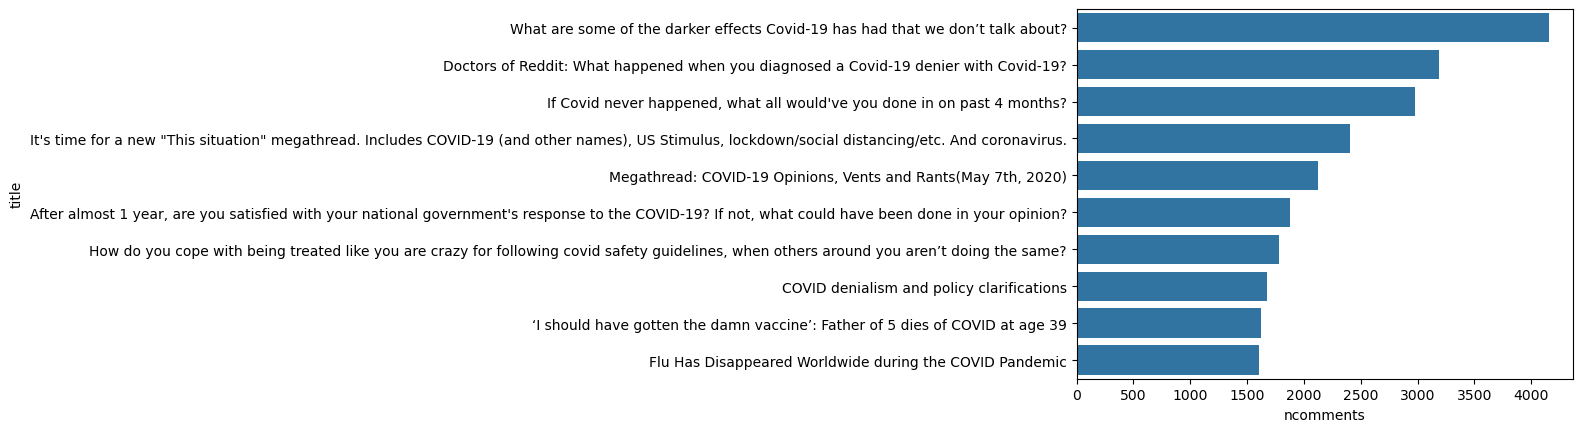

In [ ]:
sns.barplot(data=top_10_count_comentarios, y='title', x='ncomments')

In [ ]:
conexion.query("select max(created_at) from posts").df()

,max(created_at)
0,2021-10-25 18:59:39


In [ ]:
conexion.query("select min(created_at) from posts").df()

,min(created_at)
0,2020-02-11 10:10:58


In [ ]:
conexion.query("select max(created_at) from comments").df()

,max(created_at)
0,2021-10-25 18:59:59


In [ ]:
conexion.query("select min(created_at) from comments").df()


,min(created_at)
0,2019-12-04 08:24:34


Post y comentarios creados despues del anuncio de covid por diciembre del 2019, algunos comentarios estan desde inicios de diciembre, algunos de ellos fueron editados para mencionar algo relacionado con covid, los ultimos comentarios y posts recolectados tienen fecha de 25 de octubre del 2021 asi que es informacion de aproximadamente 2 años

In [ ]:
posts_por_meses = conexion.query("select date_trunc('month',created_at) as mes_creacion, count(*) as nposts  from posts group by date_trunc('month',created_at)").df()

In [ ]:
posts_por_meses.head()

,mes_creacion,nposts
0,2020-02-01,14004
1,2020-03-01,369773
2,2020-04-01,387024
3,2020-05-01,285878
4,2020-06-01,193166


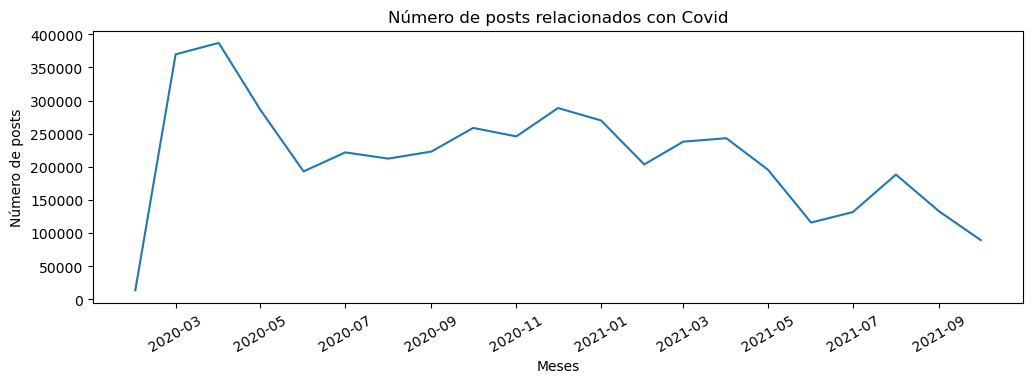

In [ ]:
#pal = sns.color_palette("Oranges_r_d", len(top_10_score_subreddits))
fig, ax = plt.subplots(figsize = (12,4))  
ax = sns.lineplot(data=posts_por_meses, y='nposts', x='mes_creacion', ax=ax)
plt.title('Número de posts relacionados con Covid')
plt.ylabel('Número de posts')
plt.xlabel('Meses')
fig.autofmt_xdate(ha='center')

In [ ]:
comments_por_meses = conexion.query("select date_trunc('month',created_at) as mes_creacion, count(*) as ncomments  from comments group by date_trunc('month',created_at)").df()

In [ ]:
from datetime import time as dtime
import matplotlib.ticker as tkr
import matplotlib.dates as mdates

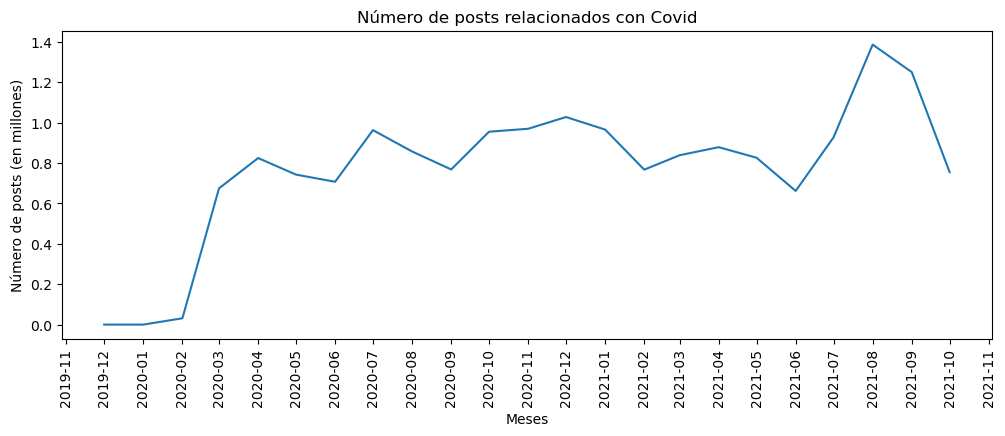

In [ ]:
comments_por_meses['ncomments_millones'] = comments_por_meses['ncomments']/1000000
fig, ax = plt.subplots(figsize = (12,4))  
ax = sns.lineplot(data=comments_por_meses, y='ncomments_millones', x='mes_creacion', ax=ax)
plt.title('Número de comentarios relacionados con Covid')
plt.ylabel('Número de comentarios (en millones)')
plt.xlabel('Meses')
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)

In [ ]:
comments_por_meses['ncomments'].sum()

17777408

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
comments_por_horas_del_dia = conexion.query("select hour(created_at) as hora_del_dia, count(*) as ncomments  from comments group by hour(created_at) order by hour(created_at) asc").df()

In [ ]:
comments_por_horas_del_dia

,hora_del_dia,ncomments,ncomments_millones
0,0,568479,0.568479
1,1,494320,0.494320
2,2,429539,0.429539
3,3,393473,0.393473
4,4,383979,0.383979
5,5,409715,0.409715
6,6,489019,0.489019
7,7,622106,0.622106
8,8,758101,0.758101
9,9,892109,0.892109


In [ ]:
comments_por_horas_del_dia['ncomments'].sum()

17777408

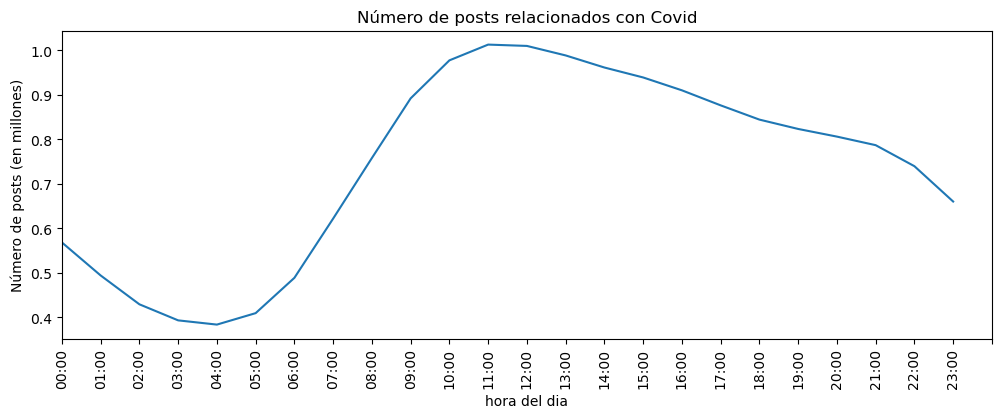

In [ ]:
comments_por_horas_del_dia['ncomments_millones'] = comments_por_horas_del_dia['ncomments']/1000000
fig, ax = plt.subplots(figsize = (12,4))  
ax = sns.lineplot(data=comments_por_horas_del_dia, y='ncomments_millones', x='hora_del_dia', ax=ax)
plt.title('Número de Comentarios relacionados con Covid')
plt.ylabel('Número de Comentarios (en millones)')
plt.xlabel('hora del dia')
hours = [dtime(i).strftime('%H:%M') for i in range(24)] + ['']
ax.set_xlim(0, 24)
ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
ax.set_xticks(ticks=ax.get_xticks()[1:-1], labels=hours, rotation=90)

In [ ]:
posts_count_comentarios = conexion.query("select post_id, length(title) as longitud_post, post_score, count(*) as ncomments from COMMENTS_WITH_POSTS where title is not null group by post_id, length(title), post_score").to_df()
posts_count_comentarios

,post_id,longitud_post,post_score,ncomments
0,q80xqn,60,8353,130
1,q7o5bp,85,24,32
2,q7z99k,42,3,1
3,q7z578,71,213,7
4,q7iygp,82,27,2
...,...,...,...,...
718494,fezi03,63,2,1
718495,fey2h5,274,1,1
718496,fevp8g,243,45,1
718497,fevlqh,83,452,2


In [ ]:
posts_count_comentarios

,post_id,longitud_post,post_score,ncomments
0,q2oja1,232,97,20
1,q2tx8r,166,1,1
2,q27wn1,124,134,12
3,q2bsp8,53,113,15
4,q2ltb0,65,1878,39
...,...,...,...,...
718494,ffgh07,72,1,1
718495,fetuu3,75,375,1
718496,feet23,103,40,1
718497,fexowd,35,54,1


In [ ]:
standard_scaler = preprocessing.StandardScaler()
posts_count_comentarios[['longitud_post', 'post_score', 'ncomments']] = standard_scaler.fit_transform(posts_count_comentarios[['longitud_post', 'post_score', 'ncomments']])  

Text(0.5, 0, 'longitud título del Post')

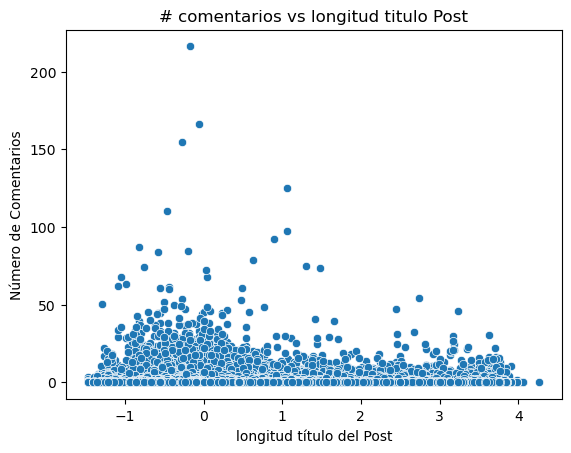

In [ ]:
sns.scatterplot(data=posts_count_comentarios, x='longitud_post', y='ncomments' )
plt.title('# comentarios vs longitud titulo Post')
plt.ylabel('Número de Comentarios')
plt.xlabel('longitud título del Post')

Text(0.5, 0, 'Score Normalizado')

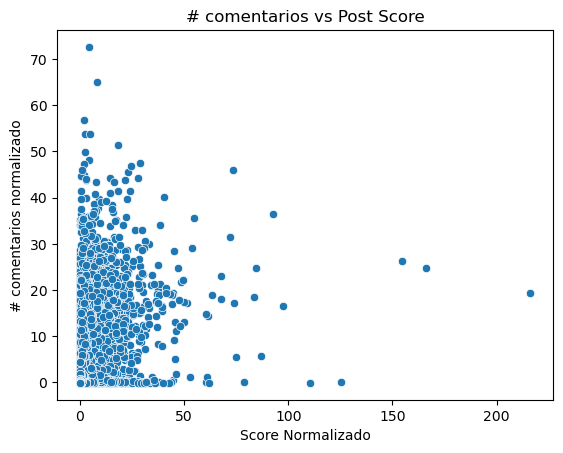

In [ ]:
sns.scatterplot(data=posts_count_comentarios, x='ncomments', y='post_score' )
plt.title('# comentarios vs Post Score')
plt.ylabel('# comentarios normalizado')
plt.xlabel('Score Normalizado')

Text(0.5, 0, 'Score Normalizado')

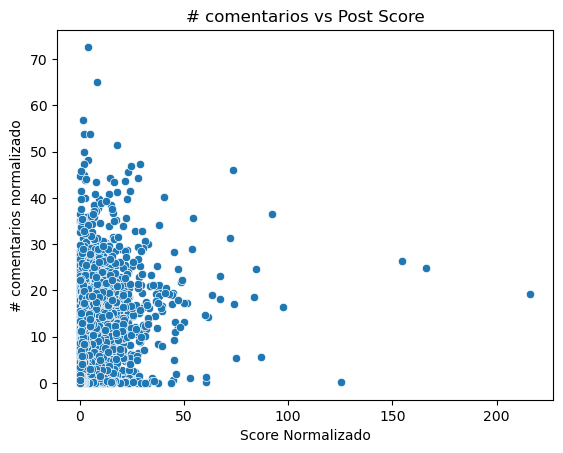

In [ ]:
sns.scatterplot(data=posts_count_comentarios[(posts_count_comentarios['ncomments']>0) & (posts_count_comentarios['post_score']>0)], x='ncomments', y='post_score' )
plt.title('# comentarios vs Post Score')
plt.ylabel('# comentarios normalizado')
plt.xlabel('Score Normalizado')

## Grafo: Top 20 Dominios con Más Conexiones

In [ ]:
import polars as pl
import networkx as nx

In [ ]:
posts_df = conexion.query("SELECT * FROM POSTS WHERE EXTRACT(YEAR FROM CREATED_AT) = 2021 AND EXTRACT(MONTH FROM CREATED_AT) = 10;").fetchdf()
comments_df = conexion.query("SELECT * FROM COMMENTS WHERE EXTRACT(YEAR FROM CREATED_AT) = 2021 AND EXTRACT(MONTH FROM CREATED_AT) = 10 LIMIT 10000").fetchdf()

In [ ]:
pl_posts_df = pl.from_pandas(posts_df)
pl_comments_df = pl.from_pandas(comments_df)

In [ ]:
joined_pl = pl_comments_df.join(pl_posts_df, left_on="POST_ID", right_on="id", how="inner")
joined_pl = joined_pl.select(["id", "domain"])
domain_counts = joined_pl.group_by("domain").count()

/tmp/ipykernel_26515/2179131227.py:3: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  domain_counts = joined_pl.group_by("domain").count()


In [ ]:
# Ordenar por las conexiones (número de veces que aparece cada dominio)
domain_counts = domain_counts.sort("count", descending=True)
# Se seleccionan los 20 dominios con más conexiones
top_20_domains = domain_counts.head(20)
# Filtrar los datos originales para que solo incluyan los dominios en el top 20
filtered_pl = joined_pl.filter(pl.col("domain").is_in(top_20_domains["domain"]))
# Convertir a pandas para NetworkX
filtered_pd = filtered_pl.to_pandas()

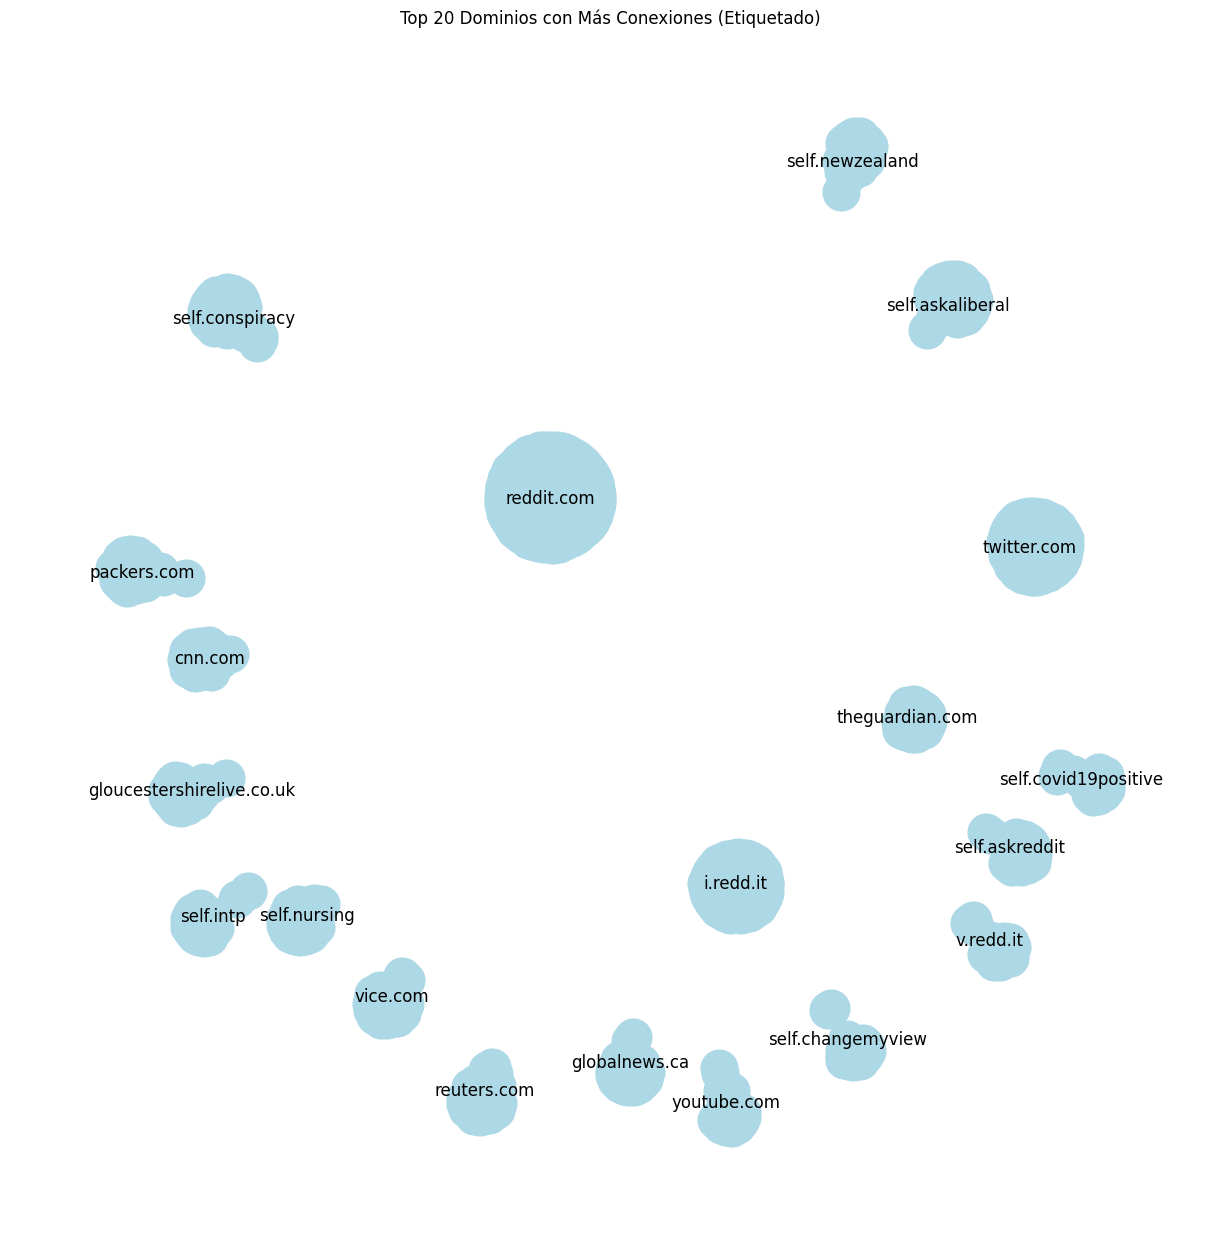

In [ ]:
# Crear el grafo en NetworkX
G = nx.from_pandas_edgelist(filtered_pd, 'id', 'domain')
labels = {node: node for node in G.nodes if '.' in node}  # Esto asume que los dominios contienen un punto (.)
# Dibujar el grafo solo con los nombres de los dominios como etiquetas
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Usamos una disposición tipo spring
nx.draw(G, pos, with_labels=False, node_size=700, node_color="lightblue", font_size=10)
# Agregar las etiquetas solo a los dominios
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color="black")

plt.title("Top 20 Dominios con Más Conexiones (Etiquetado)")
plt.show()

**reddit.com** es el nodo más grande y, por lo tanto, el que tiene más conexiones. Esto indica que una gran cantidad de comentarios están relacionados con el dominio principal de Reddit.

Otros dominios importantes como twitter.com, vice.com, youtube.com, cnn.com, y reuters.com también tienen un alto número de conexiones, se puede decir que reciben mucha atención.

## Scarterplot para relación entre sentimiento y score de comentarios

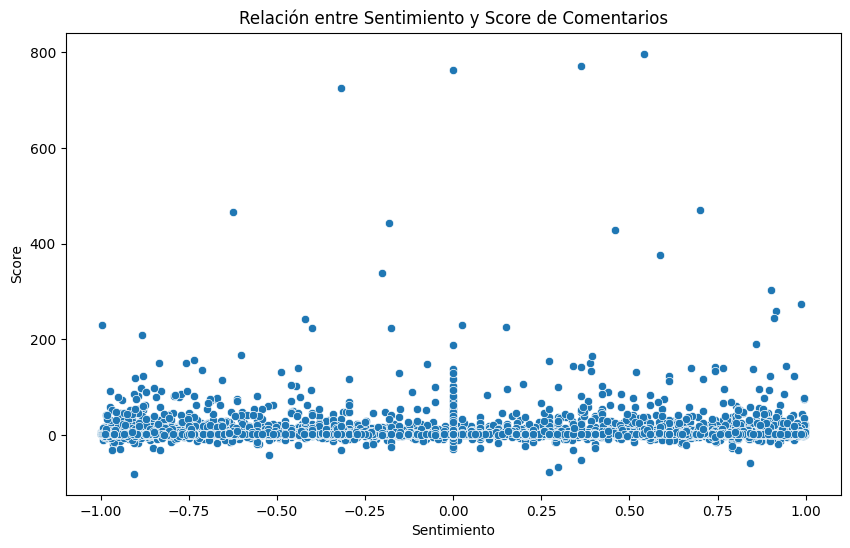

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment', y='score', data=comments_df)

# Etiquetas y título
plt.title('Relación entre Sentimiento y Score de Comentarios')
plt.xlabel('Sentimiento')
plt.ylabel('Score')

# Mostrar el gráfico
plt.show()

- Hay una alta concentración de comentarios alrededor de 0 en el eje X (sentimiento neutral), lo cual indica que la mayoría de los comentarios tienen una valoración de sentimiento neutral o cercana a ello.
- Los comentarios neutros tienen una gran dispersión de puntajes (score) en el eje Y, lo cual sugiere que los comentarios neutrales pueden recibir tanto puntuaciones altas como bajas.

No parece haber una correlación clara entre el sentimiento y el score, ya que los puntos están bastante dispersos.

## Grafo usando PyGraphFrames

In [ ]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

In [ ]:
spark = SparkSession.builder.appName("RedditGraph").getOrCreate()

24/09/06 19:12:27 WARN Utils: Your hostname, eeveloza-MS-7D98 resolves to a loopback address: 127.0.1.1; using 192.168.100.42 instead (on interface wlo1)
24/09/06 19:12:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/06 19:12:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
spark = SparkSession.builder.appName("RedditGraph").getOrCreate()

24/09/07 16:01:02 WARN Utils: Your hostname, eeveloza-MS-7D98 resolves to a loopback address: 127.0.1.1; using 192.168.100.42 instead (on interface wlo1)
24/09/07 16:01:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/07 16:01:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
spark_posts_df = spark.createDataFrame(posts_df)
spark_comments_df = spark.createDataFrame(comments_df)

In [ ]:
# Los nodos serán los IDs de los comentarios y los dominios de los posts
vertices = (spark_posts_df.selectExpr("id as id", "domain as name")
            .union(spark_comments_df.selectExpr("id as id", "'comment' as name")))

# Aristas: Definir las relaciones entre comentarios y dominios de posts
edges = spark_comments_df.selectExpr("id as src", "POST_ID as dst")

In [ ]:
# Crear el grafo
g = GraphFrame(vertices, edges)

g.vertices.show(5)
g.edges.show(5)

Se tuvo un error con la clase org.graphframes.GraphFramePythonAPI en el entorno de Java, el cual no se logró solventar. Se probó ejecutándolo desde Google Collab y se tuvo el mismo error. Se colocó el código para sustentar que se intentó usar la librería **GraphFrame en PySpark**